In [5]:
import pandas as pd
import numpy as np
import pathlib as pl
import os
import requests

# Get ASEC data from CPS API

## Variables to Retrieve

In [68]:
ASEC_VARIABLES = [
    'PEMLR', # labor force status
    'WKSWORK', # weeks worked last year
    'A_AGE',
    'A_SEX',
    'A_HGA',
    'PRDTRACE',
    'PEHSPNON',
    'PRDISFLG',
    'PRCITSHP',
    'MARSUPWT',
    'A_LFSR',
    'HRCHECK',
    'A_CLSWKR',
    'CLWK',
    'A_DTOCC', # last year major occ
    'WEMIND', # last year major ind
    'A_MJIND',
    'LJCW',
    'HTOTVAL',
    'A_MARITL',
    'FPERSONS',  # number of persons in family
    'FRELU18',  # number of persons in family under 18
]

## Get single year of ASEC data

In [24]:
# this function will retrieve an entire year of ASEC data
def get_asec_year_df(api_key, asec_variables, year):
    base_url = f'https://api.census.gov/data/{year}/cps/asec/mar'
    get_vars = ','.join(asec_variables)
    url = f'{base_url}?get={get_vars}&key={api_key}'
    response = requests.get(url)
    
    data = response.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    
    df = df.rename(columns={x: x.lower() for x in df.columns})
    df.loc[:, 'year'] = year
    
    for var in df.columns:
        if var == 'marsupwt':
            df[var] = df[var].astype(np.float64)
        else:
            df[var] = df[var].astype(np.int64)
            
    return df

# I've saved my API key in a local file
with open('c:/users/calvi/coding/census_api_key.txt', 'r') as f:
    api_key = f.readline().strip()

asec_2024 = get_asec_year_df(api_key, ASEC_VARIABLES, 2024)
asec_2024.head()

,a_age,a_sex,a_hga,prdtrace,pehspnon,prdisflg,prcitshp,marsupwt,a_lfsr,hrcheck,...,a_dtocc,wemind,a_mjind,ljcw,pearnval,htotval,a_maritl,fpersons,frelu18,year
0,68,2,39,1,2,2,1,1061.89,1,2,...,17,4,10,1,55000,262579,1,2,0,2024
1,68,1,43,1,2,2,1,1061.89,1,2,...,16,5,5,1,24000,262579,1,2,0,2024
2,58,2,44,1,2,1,1,4788.10,1,2,...,8,10,10,4,95000,96802,5,1,0,2024
3,71,2,43,1,2,2,1,5180.75,7,0,...,0,15,0,0,0,104000,1,2,0,2024
4,70,1,46,1,2,2,1,5180.75,7,2,...,0,10,0,1,55000,104000,1,2,0,2024


In [69]:
asec_df = pd.DataFrame()
base_year = 2024
start_year = base_year - 9
for year in range(start_year, base_year + 1):
    print(f'Processing year {year}')
    df_year = get_asec_year_df(api_key, ASEC_VARIABLES, year)
    asec_df = pd.concat([
        asec_df,
        df_year
    ])

asec_df.head()

Processing year 2015
Processing year 2016
Processing year 2017
Processing year 2018
Processing year 2019
Processing year 2020
Processing year 2021
Processing year 2022
Processing year 2023
Processing year 2024


,pemlr,a_age,a_sex,a_hga,prdtrace,pehspnon,prdisflg,prcitshp,marsupwt,a_lfsr,...,a_dtocc,wemind,a_mjind,ljcw,pearnval,htotval,a_maritl,fpersons,frelu18,year
0,1,48,1,41,1,2,2,1,690.05,1,...,22,2,6,1,40000,63930,1,2,0,2015
1,6,45,2,40,2,2,2,1,690.05,7,...,0,11,0,1,6000,63930,1,2,0,2015
2,1,23,2,39,1,2,2,1,583.80,1,...,16,5,5,1,16000,63930,3,2,1,2015
3,0,2,2,0,1,2,-1,1,468.04,0,...,0,0,0,0,0,63930,7,2,1,2015
4,5,80,2,39,1,2,1,1,735.83,7,...,0,15,0,0,0,11831,4,1,0,2015


## Save raw ASEC data to parquet

In [70]:
parquets_dir = pl.Path('model.ipynb').resolve().parent/'parquets'
if not os.path.exists(str(parquets_dir)):
    os.makedirs(str(parquets_dir))
parquet_file_path = parquets_dir/f'asec_{start_year}to{base_year}.parquet'

asec_df.to_parquet(parquet_file_path)

# Transform ASEC data to prepare for modeling

In [74]:
parquets_dir = pl.Path('model.ipynb').resolve().parent/'parquets'
parquet_file_path = parquets_dir/f'asec_{start_year}to{base_year}.parquet'
asec = pd.read_parquet(parquet_file_path)

## Remove rows

Starting with 1,695,000 rows

In [75]:
print(f'Starting with {len(asec)} rows')
def remove_rows(df):
    df = df.copy()

    # only include people who worked in paying jobs last year
    df = df[df.ljcw.isin([1,2,3,4,5,6])].reset_index(drop=True)

    # only include people who worked more than 30 weeks
    df = df[df.wkswork > 30]

    return df

asec = remove_rows(asec)
print(f'Now we have {len(asec)} rows')

Starting with 1695242 rows
Now we have 749223 rows


## Create modeling variables

### Education

In [76]:
def get_edu_var(df):
    df = df.copy()
    bins = [30, 39, 40, 41, 43, 44, 45, np.inf]
    names = ['LTHS', 'HS', 'SCND', 'AD', 'BA', 'MA', 'DOC']
    df['edu'] = pd.cut(df['a_hga'], bins, labels=names, right=False)
    
    return df

asec = get_edu_var(asec)
asec.edu.value_counts()

edu
HS      195242
BA      179803
SCND    123978
AD       82165
MA       79391
LTHS     58761
DOC      29883
Name: count, dtype: int64

### Race

In [77]:
def get_race_var(df):
    df = df.copy()
    df['race'] = 'other'
    df.loc[df.prdtrace == 1, 'race'] = 'white'
    df.loc[df.prdtrace == 2, 'race'] = 'black'
    df.loc[df.prdtrace == 4, 'race'] = 'asian'
    
    return df

asec = get_race_var(asec)
asec.race.value_counts()

race
white    586838
black     82591
asian     50951
other     28843
Name: count, dtype: int64

### Hispanic

In [78]:
def get_hispanic_var(df):
    df = df.copy()
    df['hisp'] = 0
    df.loc[df.pehspnon==1, 'hisp'] = 1
    
    return df

asec = get_hispanic_var(asec)
asec.hisp.value_counts()

hisp
0    607253
1    141970
Name: count, dtype: int64

### Sex

In [79]:
def get_male_var(df):
    df = df.copy()
    df['male'] = 0
    df.loc[df.a_sex==1, 'male'] = 1
    
    return df

asec = get_male_var(asec)
asec.male.value_counts()

male
1    395814
0    353409
Name: count, dtype: int64

### Citizenship

In [80]:
def get_citizenship_var(df):
    df = df.copy()
    bins = [1, 4, 5, np.inf]
    names = ['native', 'naturalized', 'noncitizen']
    df.loc[:, 'citshp'] = pd.cut(df['prcitshp'],
                                 bins=bins, labels=names, right=False, include_lowest=True)
    
    return df

asec = get_citizenship_var(asec)
asec.citshp.value_counts()

citshp
native         616774
noncitizen      67602
naturalized     64847
Name: count, dtype: int64

### Class of worker

In [81]:
def get_cow_var(df):
    df = df.copy()
    bins = [1, 2, 5, 6, np.inf]
    names = ['ws', 'gov', 'seinc', 'seuninc']
    df.loc[:, 'cow'] = pd.cut(df['ljcw'],
                                 bins=bins, labels=names, 
                                 right=False, include_lowest=True)
    
    return df

asec = get_cow_var(asec)
asec.cow.value_counts()

cow
ws         561711
gov        117007
seuninc     42850
seinc       27655
Name: count, dtype: int64

### Full-time/part-time

In [82]:
def get_pt_var(df):
    df = df.copy()
    df['pt'] = 0
    df.loc[df.hrcheck == 1, 'pt'] = 1
    
    return df

asec = get_pt_var(asec)
asec.pt.value_counts()

pt
0    638067
1    111156
Name: count, dtype: int64

### Disability

In [83]:
def get_disability_var(df):
    df = df.copy()
    df['disability'] = 0
    df.loc[df.prdisflg == 1, 'disability'] = 1
    
    return df

asec = get_disability_var(asec)
asec.disability.value_counts()

disability
0    719953
1     29270
Name: count, dtype: int64

### Marital Status

In [84]:
def get_married_var(df):
    df = df.copy()
    df['married'] = 0
    df.loc[df.a_maritl.isin([1,2,3]), 'married'] = 1
    
    return df

asec = get_married_var(asec)
asec.married.value_counts()

married
1    442846
0    306377
Name: count, dtype: int64

### Children

In [85]:
def get_children_var(df):
    df = df.copy()
    df['children'] = 0
    df.loc[df.frelu18 > 0, 'children'] = 1
    
    return df

asec = get_children_var(asec)
asec.children.value_counts()

children
0    412630
1    336593
Name: count, dtype: int64

### Income

#### Price levels

We need to get price level data so we can adjust incomes.

Let's retrieve CPI data from the BLS API and calculate inflation as a check.

In [89]:
import json

BLS_CPI_SERIES = 'CUUR0000SA0'  # CPI-U

# Get CPI data from BLS API 
# headers = {'Content-type': 'application/json'}
# data = json.dumps({"seriesid": [BLS_CPI_SERIES],
#                    "startyear": str(start_year - 1), 
#                    "endyear": str(base_year-  1)})
# p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', 
#                   data=data, headers=headers)
# json_data = json.loads(p.text)

cpi = pd.DataFrame(json_data['Results']['series'][0]['data'])
cpi = cpi[cpi.period == 'M12']  # only keep end of year numbers
cpi = cpi[['year', 'value']]
cpi.year = cpi.year.astype(np.int64)
cpi.value = cpi.value.astype(np.float64)
cpi = cpi.sort_values('year', ascending=False).reset_index(drop=True)
cpi['inflation'] = cpi.value / cpi.value.shift(-1) - 1
cpi

,year,value,inflation
0,2023,306.746,0.033521
1,2022,296.797,0.064544
2,2021,278.802,0.070364
3,2020,260.474,0.013620
4,2019,256.974,0.022851
5,2018,251.233,0.019102
6,2017,246.524,0.021091
7,2016,241.432,0.020746
8,2015,236.525,0.007295
9,2014,234.812,NaN


Inflation numbers look accurate. Let's Cacluate price level ratios indexed to 2023 now:

In [90]:
cpi_2023 = cpi[cpi.year == 2023].value.iloc[0]
cpi['pl_ratio'] = cpi_2023 / cpi.value
cpi

,year,value,inflation,pl_ratio
0,2023,306.746,0.033521,1.000000
1,2022,296.797,0.064544,1.033521
2,2021,278.802,0.070364,1.100229
3,2020,260.474,0.013620,1.177645
4,2019,256.974,0.022851,1.193685
5,2018,251.233,0.019102,1.220962
6,2017,246.524,0.021091,1.244285
7,2016,241.432,0.020746,1.270528
8,2015,236.525,0.007295,1.296886
9,2014,234.812,NaN,1.306347


Shift the years by 1. In any year of ASEC data, the income value is the income from the previous year.

In [91]:
cpi['year'] = cpi['year'] + 1
cpi

,year,value,inflation,pl_ratio
0,2024,306.746,0.033521,1.000000
1,2023,296.797,0.064544,1.033521
2,2022,278.802,0.070364,1.100229
3,2021,260.474,0.013620,1.177645
4,2020,256.974,0.022851,1.193685
5,2019,251.233,0.019102,1.220962
6,2018,246.524,0.021091,1.244285
7,2017,241.432,0.020746,1.270528
8,2016,236.525,0.007295,1.296886
9,2015,234.812,NaN,1.306347


Use log income because income distribution is skewed right

In [108]:
def get_log_income_var(df, cpi):
    df = df.copy()
    cpi = cpi.copy()
    
    # adjust incomes to price level
    df = df.merge(cpi[['year', 'pl_ratio']], on='year')
    df['income_adjusted'] = df.htotval * df.pl_ratio
    
    # initially set to 0
    df['log_income'] = 0.0
    # only assign log value to positive values - we will treat negative and 0 income as all having 0 here
    df.loc[df.income_adjusted > 0, 'log_income'] = \
        np.log(df[df.income_adjusted > 0].income_adjusted)
        
    # remove cpi column
    df = df.drop('pl_ratio', axis=1)
    
    return df

asec = get_log_income_var(asec, cpi)
asec.log_income.describe()

count    749223.000000
mean         11.623306
std           0.799835
min           0.000000
25%          11.163974
50%          11.666826
75%          12.119473
max          15.248864
Name: log_income, dtype: float64

### LF leaver label

In [111]:
def get_leaver_var(df):
    df = df.copy()
    df['leaver'] = 0
    df.loc[~df.pemlr.isin([1,2]), 'leaver'] = 1
    
    return df

asec = get_leaver_var(asec)
asec.leaver.value_counts()

leaver
0    709501
1     39722
Name: count, dtype: int64

In [112]:
asec.wemind.value_counts()

wemind
10    175247
5      93005
9      87106
4      74071
11     61944
3      53877
8      50297
6      41388
13     40998
12     35380
7      13491
1      12961
2       5170
14      4288
Name: count, dtype: int64

## Rename some variables

In [113]:
asec = asec.rename(columns={
    'a_dtocc': 'occ',
    'wemind': 'ind',
    'a_age': 'age'
})

asec.columns

Index(['pemlr', 'wkswork', 'age', 'a_sex', 'a_hga', 'prdtrace', 'pehspnon',
       'prdisflg', 'prcitshp', 'marsupwt', 'a_lfsr', 'hrcheck', 'a_clswkr',
       'clwk', 'occ', 'ind', 'a_mjind', 'ljcw', 'htotval', 'a_maritl',
       'fpersons', 'frelu18', 'year', 'edu', 'race', 'hisp', 'male', 'citshp',
       'cow', 'pt', 'disability', 'married', 'children', 'income_adjusted',
       'log_income', 'leaver'],
      dtype='object')

## Save modeling data

In [114]:
model_data = asec[[
    'marsupwt', 'leaver',  # weight and label
    'age', 'log_income',  # continuous variables
    'pt', 'hisp', 'male', 'disability', 'married', 'children',  # binary variables
    'cow', 'race', 'citshp', 'edu', 'occ', 'ind' # categorical variables
]].copy()

model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,cow,race,citshp,edu,occ,ind
0,690.05,0,48,11.332779,0,0,1,0,1,0,ws,white,native,AD,22,2
1,583.80,0,23,11.332779,0,0,0,0,1,1,ws,white,native,HS,16,5
2,513.98,0,64,10.463579,0,0,0,0,0,1,gov,white,native,SCND,8,10
3,785.82,0,46,11.878375,0,0,0,0,1,0,gov,white,native,HS,2,13
4,785.82,0,60,11.878375,0,0,1,0,1,0,gov,white,native,AD,1,13


In [115]:
cat_vars = ['cow', 'race', 'citshp', 'edu', 'occ', 'ind']

for var in cat_vars:
    model_data[var] = model_data[var].astype('category')

# one-hot encode categorical variables
model_data = pd.get_dummies(model_data, drop_first=True,
                            columns=cat_vars, dtype=np.int8)

model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,690.05,0,48,11.332779,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,583.80,0,23,11.332779,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2,513.98,0,64,10.463579,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,785.82,0,46,11.878375,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,785.82,0,60,11.878375,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


Save to a parquet file

In [116]:
model_data_parquet_path = parquets_dir/f'leavers_model_data{base_year}.parquet'
model_data.to_parquet(model_data_parquet_path)

print(f'Saved model data as a parquet file: {str(model_data_parquet_path)}')

Saved model data as a parquet file: C:\Users\calvi\github\asec-separations-model\parquets\leavers_model_data2024.parquet


# Do some modeling

In [117]:
model_data = pd.read_parquet(model_data_parquet_path)
model_data.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,690.05,0,48,11.332779,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,583.80,0,23,11.332779,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,0
2,513.98,0,64,10.463579,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,785.82,0,46,11.878375,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,785.82,0,60,11.878375,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Train-test split

In [118]:
sample = model_data.sample(500000, random_state=42).reset_index(drop=True)

sample.shape

(500000, 60)

In [119]:
from sklearn.preprocessing import StandardScaler

continuous_features = ['age', 'log_income']
scaler = StandardScaler()
sample[continuous_features] = scaler.fit_transform(sample[continuous_features])

sample.head()

,marsupwt,leaver,age,log_income,pt,hisp,male,disability,married,children,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
0,900.10,0,1.366685,-1.261003,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,274.52,0,0.355233,0.425198,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1674.02,0,-1.378686,0.360308,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,1982.69,0,0.933206,0.357179,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3069.47,0,-0.367233,-0.027990,0,0,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0


Get train-test split

In [120]:
from sklearn.model_selection import train_test_split

X = sample.drop(columns=['leaver', 'marsupwt'])
y = sample['leaver']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('training #:', len(X_train))
print('testing #:', len(X_test))

training #: 400000
testing #: 100000


## PCA

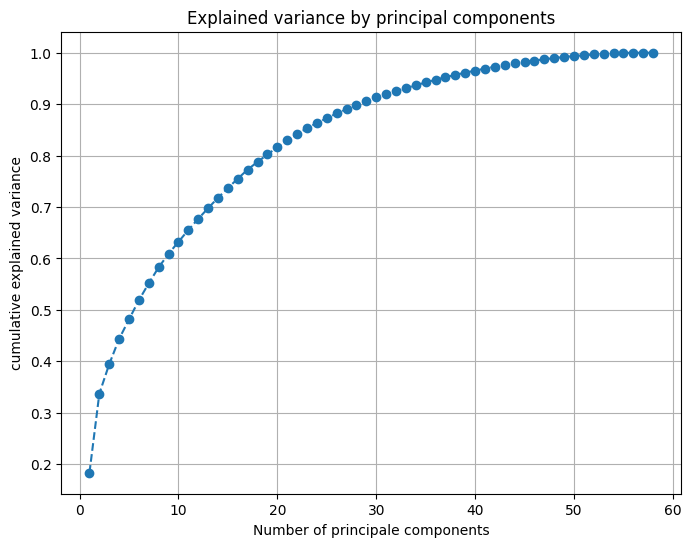

In [121]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA



# Run PCA, reducing the data to 2 components
pca = PCA()
pca.fit(X_train)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1),
        explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of principale components")
plt.ylabel("cumulative explained variance")
plt.title("Explained variance by principal components")
plt.grid()
plt.show()


In [122]:
component_df = pd.DataFrame(pca.components_, columns=X.columns,
                             index=[f'PC{i+1}' for i in range(pca.n_components_)])
display(component_df)

,age,log_income,pt,hisp,male,disability,married,children,cow_gov,cow_seinc,...,ind_5,ind_6,ind_7,ind_8,ind_9,ind_10,ind_11,ind_12,ind_13,ind_14
PC1,6.276771e-01,0.721335,-0.046451,-0.073196,0.017118,0.002048,0.207645,-0.033658,0.034251,0.022874,...,-0.028283,0.001174,0.003134,0.020189,0.021594,0.029169,-0.048073,-0.006499,0.016381,-0.002143
PC2,7.488296e-01,-0.633141,0.024434,0.009181,-0.009598,0.026836,0.004396,-0.140211,-0.000362,0.003384,...,0.004137,0.008983,-0.004371,-0.008796,-0.017456,-0.004235,-0.009006,0.012885,-0.002097,-0.002971
PC3,1.677699e-03,0.039255,-0.107440,0.126629,0.645036,-0.001152,0.109747,0.026172,-0.207520,0.029748,...,0.084367,0.054562,0.005374,0.009201,0.059830,-0.497747,0.019428,0.013047,-0.025510,0.002560
PC4,-3.885237e-05,-0.177831,-0.022052,0.075394,-0.016830,-0.018836,0.586058,0.702058,0.079127,0.003957,...,-0.072111,-0.012572,-0.005280,-0.013311,-0.022560,0.126758,-0.046571,-0.000019,0.007421,0.007319
PC5,-2.117092e-02,-0.156243,-0.118667,-0.188943,0.337230,-0.005973,0.039347,-0.029935,0.051406,0.016393,...,-0.061849,0.001345,0.014227,0.044006,0.111137,-0.109239,-0.042998,-0.014971,0.049251,0.006443
PC6,1.007544e-02,-0.028373,0.112011,0.224316,-0.143615,0.010244,-0.123561,-0.225352,-0.109992,0.012207,...,0.054886,-0.046996,0.004037,0.033616,0.042054,-0.051159,0.026781,0.011313,-0.044852,-0.006323
PC7,-5.928802e-02,-0.029456,-0.211113,0.093072,0.406758,-0.002387,-0.054912,-0.267065,0.409649,-0.030508,...,-0.291512,0.014904,-0.007869,-0.103974,-0.105138,0.398560,-0.086251,-0.039460,0.108402,0.012927
PC8,2.362739e-02,0.022570,0.061178,0.030629,0.168014,0.012885,-0.033076,0.035231,0.067407,0.000049,...,0.014712,0.017366,-0.001866,-0.029197,-0.049682,0.002274,0.012070,-0.003829,0.032499,0.005687
PC9,4.202781e-02,0.055157,-0.054845,0.704804,-0.117238,-0.022732,-0.064974,0.013551,-0.157689,-0.001214,...,-0.274004,-0.013006,-0.002159,-0.003269,0.174908,-0.004202,0.084888,0.016610,-0.069459,-0.009634
PC10,1.252564e-02,0.029909,-0.099428,0.341894,-0.066911,-0.008015,0.055663,-0.010036,0.540237,-0.047890,...,0.310411,0.048642,-0.002785,0.004832,-0.162243,-0.222360,-0.075564,-0.032824,0.312348,0.019204


In [124]:
explained_variance_ratio = pca.explained_variance_ratio_

# Rank the importance of variables
importance_rank = np.argsort(explained_variance_ratio)[::-1]

# Print the ranked variables
for i, var_index in enumerate(importance_rank[:10]):
    print(f"Rank {i+1}: Variable {X.columns[var_index]}")

Rank 1: Variable age
Rank 2: Variable log_income
Rank 3: Variable pt
Rank 4: Variable hisp
Rank 5: Variable male
Rank 6: Variable disability
Rank 7: Variable married
Rank 8: Variable children
Rank 9: Variable cow_gov
Rank 10: Variable cow_seinc


In [125]:
features_pca = pca.fit_transform(X_train)
features_pca

array([[ 5.63227848e-01, -6.85100008e-01, -3.16199246e-02, ...,
        -3.05075892e-03,  1.63830718e-02,  1.30118158e-04],
       [-1.03754458e+00,  3.69969859e-02, -6.63067235e-01, ...,
         2.43806108e-03,  2.68754810e-03,  8.08720156e-05],
       [-2.33120122e+00,  5.43659856e-02, -6.67521448e-01, ...,
         5.54681776e-03,  3.03768980e-03, -8.39895334e-05],
       ...,
       [-9.49904848e-01, -1.18933326e+00, -5.30159181e-01, ...,
         1.02860708e-02, -2.45004613e-03,  1.89872802e-06],
       [ 3.97721757e-02, -1.24208368e+00, -2.72207151e-01, ...,
        -5.52622957e-03,  5.12936501e-03, -2.19408216e-05],
       [ 3.07991947e-01, -6.91310817e-01,  3.10148608e-01, ...,
         1.71059305e-02, -1.70128257e-03,  2.50181864e-05]],
      shape=(400000, 58))

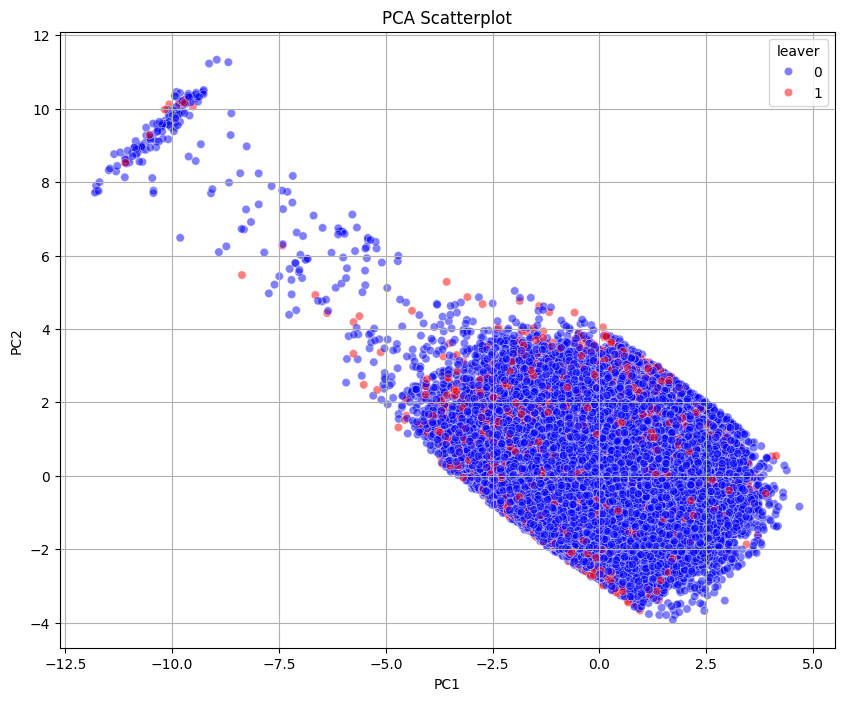

In [126]:
import seaborn as sns

pca_df = pd.DataFrame(features_pca,
                      columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_df['leaver'] = y_train.values


plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='leaver', alpha=0.5, palette=['blue', 'red'])
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

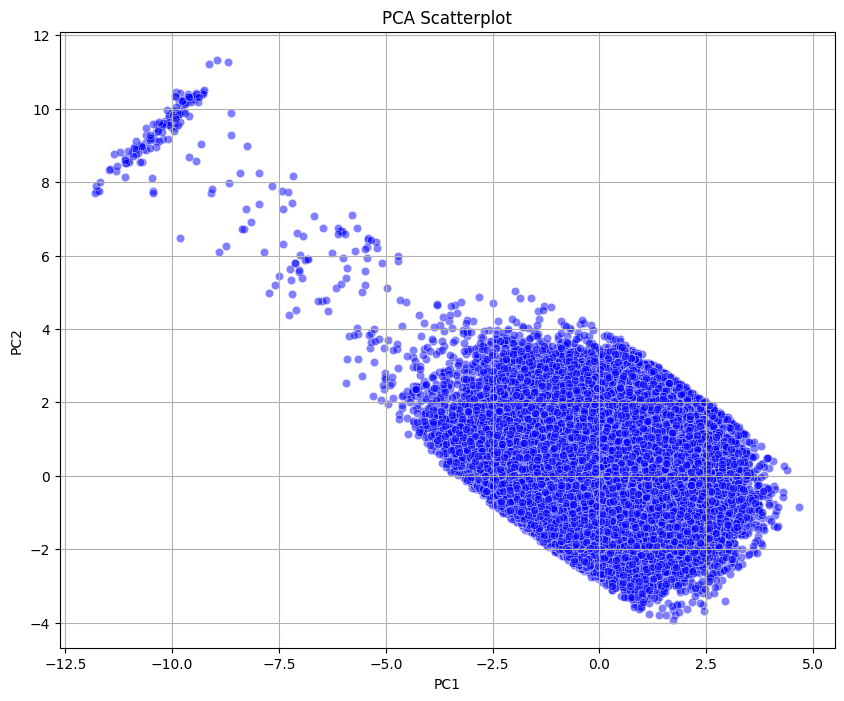

In [127]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df[pca_df.leaver==0], x='PC1', y='PC2', 
                alpha=0.5, color='blue')
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

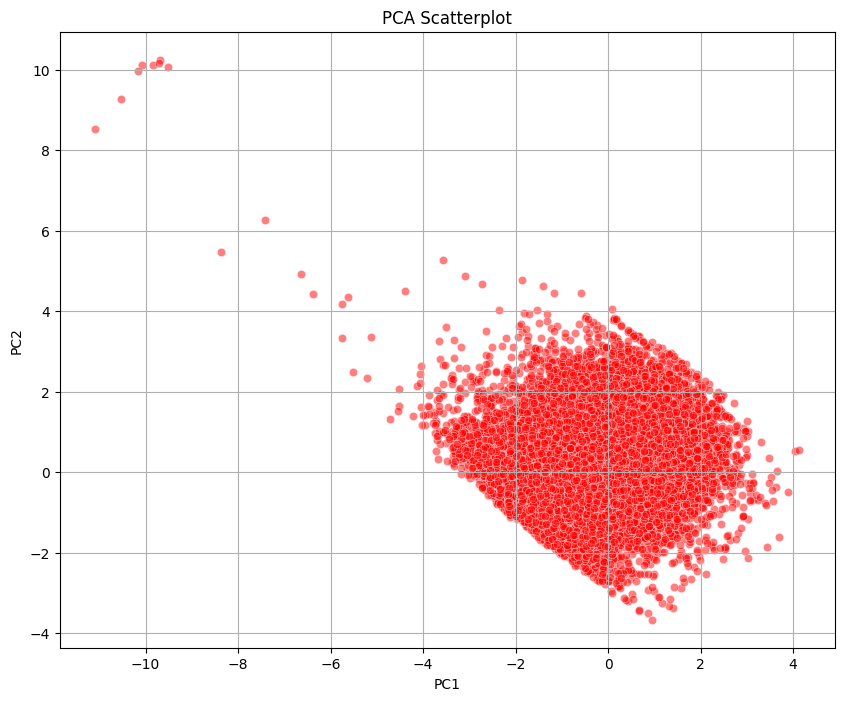

In [128]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df[pca_df.leaver==1], x='PC1', y='PC2', 
                alpha=0.5, color='red')
plt.title('PCA Scatterplot')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

In [129]:
y.sum()/len(y)

np.float64(0.052926)